In [17]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import matplotlib.patches as patches

FloatTensor = torch.FloatTensor

def is_tuple(x): 
    res = isinstance(x, tuple)
    return res

In [18]:
def create_grid(size):
    'Create a Grid of Given Size'
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

In [19]:
def show_anchors(ancs, size):
    """Function to Draw the Anchors"""
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

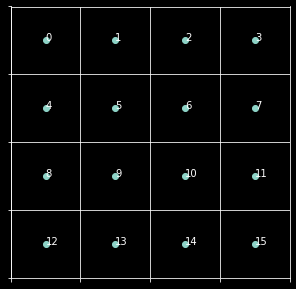

In [20]:
size = (4,4)
show_anchors(create_grid(size), size)

In [21]:
create_grid(size)

tensor([[-0.7500, -0.7500],
        [-0.7500, -0.2500],
        [-0.7500,  0.2500],
        [-0.7500,  0.7500],
        [-0.2500, -0.7500],
        [-0.2500, -0.2500],
        [-0.2500,  0.2500],
        [-0.2500,  0.7500],
        [ 0.2500, -0.7500],
        [ 0.2500, -0.2500],
        [ 0.2500,  0.2500],
        [ 0.2500,  0.7500],
        [ 0.7500, -0.7500],
        [ 0.7500, -0.2500],
        [ 0.7500,  0.2500],
        [ 0.7500,  0.7500]])

In [23]:
from torchvision import models

In [30]:
m1 = models.resnet18()
m2 = models.resnet34()
m3 = models.resnet50()

In [31]:
outputs = {}
def hook_output(self, input, output):
    outputs[self] = output

In [32]:
m1.layer2.register_forward_hook(hook_output)
m1.layer3.register_forward_hook(hook_output)
m1.layer4.register_forward_hook(hook_output)

In [33]:
_ = m1(torch.ones(1, 3, 600, 600))

In [38]:
outputs[m1.layer2].shape

torch.Size([1, 128, 75, 75])

In [39]:
600/75

8.0

In [40]:
outputs[m1.layer3].shape

torch.Size([1, 256, 38, 38])

In [41]:
600/38

15.789473684210526

In [79]:
import torch
from torch import nn
from torch.jit.annotations import List, Optional, Dict


class AnchorGenerator(nn.Module):
    """
    Module that generates anchors for a set of feature maps and
    image sizes.
    The module support computing anchors at multiple sizes and aspect ratios
    per feature map. This module assumes aspect ratio = height / width for
    each anchor.
    sizes and aspect_ratios should have the same number of elements, and it should
    correspond to the number of feature maps.
    sizes[i] and aspect_ratios[i] can have an arbitrary number of elements,
    and AnchorGenerator will output a set of sizes[i] * aspect_ratios[i] anchors
    per spatial location for feature map i.
    Arguments:
        sizes (Tuple[Tuple[int]]):
        aspect_ratios (Tuple[Tuple[float]]):
    """

    __annotations__ = {
        "cell_anchors": Optional[List[torch.Tensor]],
        "_cache": Dict[str, List[torch.Tensor]]
    }

    def __init__(
        self,
        sizes=tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [32, 64, 128, 256, 512]),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5,
    ):
        super(AnchorGenerator, self).__init__()

        if not isinstance(sizes[0], (list, tuple)):
            # TODO change this
            sizes = tuple((s,) for s in sizes)
        if not isinstance(aspect_ratios[0], (list, tuple)):
            aspect_ratios = (aspect_ratios,) * len(sizes)

        assert len(sizes) == len(aspect_ratios)

        self.sizes = sizes
        self.aspect_ratios = aspect_ratios
        self.cell_anchors = None
        self._cache = {}

    # TODO: https://github.com/pytorch/pytorch/issues/26792
    # For every (aspect_ratios, scales) combination, output a zero-centered anchor with those values.
    # (scales, aspect_ratios) are usually an element of zip(self.scales, self.aspect_ratios)
    # This method assumes aspect ratio = height / width for an anchor.
    def generate_anchors(self, scales, aspect_ratios, dtype=torch.float32, device="cpu"):
        # type: (List[int], List[float], int, Device) -> Tensor  # noqa: F821
        scales = torch.as_tensor(scales, dtype=dtype, device=device)
        aspect_ratios = torch.as_tensor(aspect_ratios, dtype=dtype, device=device)
        h_ratios = torch.sqrt(aspect_ratios)
        w_ratios = 1 / h_ratios

        ws = (w_ratios[:, None] * scales[None, :]).view(-1)
        hs = (h_ratios[:, None] * scales[None, :]).view(-1)

        base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2
        return base_anchors.round()

    def set_cell_anchors(self, dtype, device):
        # type: (int, Device) -> None  # noqa: F821
        if self.cell_anchors is not None:
            cell_anchors = self.cell_anchors
            assert cell_anchors is not None
            # suppose that all anchors have the same device
            # which is a valid assumption in the current state of the codebase
            if cell_anchors[0].device == device:
                return

        cell_anchors = [
            self.generate_anchors(
                sizes,
                aspect_ratios,
                dtype,
                device
            )
            for sizes, aspect_ratios in zip(self.sizes, self.aspect_ratios)
        ]
        self.cell_anchors = cell_anchors

    def num_anchors_per_location(self):
        return [len(s) * len(a) for s, a in zip(self.sizes, self.aspect_ratios)]

    # For every combination of (a, (g, s), i) in (self.cell_anchors, zip(grid_sizes, strides), 0:2),
    # output g[i] anchors that are s[i] distance apart in direction i, with the same dimensions as a.
    def grid_anchors(self, grid_sizes, strides):
        # type: (List[List[int]], List[List[Tensor]]) -> List[Tensor]
        anchors = []
        cell_anchors = self.cell_anchors
        assert cell_anchors is not None

        for size, stride, base_anchors in zip(
            grid_sizes, strides, cell_anchors
        ):
            grid_height, grid_width = size
            stride_height, stride_width = stride
            device = base_anchors.device

            # For output anchor, compute [x_center, y_center, x_center, y_center]
            shifts_x = torch.arange(
                0, grid_width, dtype=torch.float32, device=device
            ) * stride_width
            shifts_y = torch.arange(
                0, grid_height, dtype=torch.float32, device=device
            ) * stride_height
            shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x)
            shift_x = shift_x.reshape(-1)
            shift_y = shift_y.reshape(-1)
            shifts = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=1)

            # For every (base anchor, output anchor) pair,
            # offset each zero-centered base anchor by the center of the output anchor.
            anchors.append(
                (shifts.view(-1, 1, 4) + base_anchors.view(1, -1, 4)).reshape(-1, 4)
            )

        return anchors

    def cached_grid_anchors(self, grid_sizes, strides):
        # type: (List[List[int]], List[List[Tensor]]) -> List[Tensor]
        key = str(grid_sizes) + str(strides)
        if key in self._cache:
            return self._cache[key]
        anchors = self.grid_anchors(grid_sizes, strides)
        self._cache[key] = anchors
        return anchors

    def forward(self, image_list, feature_maps):
        # type: (ImageList, List[Tensor]) -> List[Tensor]
        grid_sizes = list([feature_map.shape[-2:] for feature_map in feature_maps])
        image_size = image_list.shape[-2:]
        
        dtype, device = feature_maps[0].dtype, feature_maps[0].device
        strides = [[torch.tensor(image_size[0] // g[0], dtype=torch.int64, device=device),
                    torch.tensor(image_size[1] // g[1], dtype=torch.int64, device=device)] for g in grid_sizes]
        self.set_cell_anchors(dtype, device)
        anchors_over_all_feature_maps = self.cached_grid_anchors(grid_sizes, strides)
        anchors = torch.jit.annotate(List[List[torch.Tensor]], [])
        
        for _ in range(len(feature_maps)):
            anchors_in_image = []
            for anchors_per_feature_map in anchors_over_all_feature_maps:
                anchors_in_image.append(anchors_per_feature_map)
            anchors.append(anchors_in_image)
        anchors = [torch.cat(anchors_per_image) for anchors_per_image in anchors]
        # Clear the cache in case that memory leaks.
        self._cache.clear()
        return anchors

In [80]:
ag = AnchorGenerator()

outputs[m1.layer2].shape, outputs[m1.layer4].shape, outputs[m1.layer3].shape

(torch.Size([1, 128, 75, 75]),
 torch.Size([1, 512, 19, 19]),
 torch.Size([1, 256, 38, 38]))

In [81]:
t1 = torch.ones_like(outputs[m1.layer2])
t2 = torch.ones_like(outputs[m1.layer3])
t3 = torch.ones_like(outputs[m1.layer4])
feature_maps = [t1, t2, t2]

out = ag(torch.ones((1, 3, 600, 600)), feature_maps)

In [82]:
len(out)

3

In [83]:
out

[tensor([[-23., -11.,  23.,  11.],
         [-28., -14.,  28.,  14.],
         [-35., -18.,  35.,  18.],
         ...,
         [510., 464., 600., 646.],
         [498., 441., 612., 669.],
         [483., 411., 627., 699.]]),
 tensor([[-23., -11.,  23.,  11.],
         [-28., -14.,  28.,  14.],
         [-35., -18.,  35.,  18.],
         ...,
         [510., 464., 600., 646.],
         [498., 441., 612., 669.],
         [483., 411., 627., 699.]]),
 tensor([[-23., -11.,  23.,  11.],
         [-28., -14.,  28.,  14.],
         [-35., -18.,  35.,  18.],
         ...,
         [510., 464., 600., 646.],
         [498., 441., 612., 669.],
         [483., 411., 627., 699.]])]

In [84]:
from anchors import AnchorGenerator

In [85]:
t1 = torch.ones_like(outputs[m1.layer2])
t2 = torch.ones_like(outputs[m1.layer3])
t3 = torch.ones_like(outputs[m1.layer4])
feature_maps = [t1, t2, t2]
ag_2 = AnchorGenerator()
out = ag_2(feature_maps)
len(out)

3

In [86]:
out

[tensor([[-22.6274, -11.3137,  22.6274,  11.3137],
         [-16.0000, -16.0000,  16.0000,  16.0000],
         [-11.3137, -22.6274,  11.3137,  22.6274],
         ...,
         [556.0812, 574.0406, 627.9188, 609.9594],
         [566.6016, 566.6016, 617.3984, 617.3984],
         [574.0406, 556.0812, 609.9594, 627.9188]]),
 tensor([[-45.2548, -22.6274,  45.2548,  22.6274],
         [-32.0000, -32.0000,  32.0000,  32.0000],
         [-22.6274, -45.2548,  22.6274,  45.2548],
         ...,
         [520.1624, 556.0812, 663.8376, 627.9188],
         [541.2032, 541.2032, 642.7968, 642.7968],
         [556.0812, 520.1624, 627.9188, 663.8376]]),
 tensor([[ -90.5097,  -45.2548,   90.5097,   45.2548],
         [ -64.0000,  -64.0000,   64.0000,   64.0000],
         [ -45.2548,  -90.5097,   45.2548,   90.5097],
         ...,
         [1040.3248, 1112.1625, 1327.6752, 1255.8375],
         [1082.4064, 1082.4064, 1285.5936, 1285.5936],
         [1112.1625, 1040.3248, 1255.8375, 1327.6752]])]

In [90]:
ag_2.num_anchors, ag_2.num_cell_anchors, ag_2.device

([9, 9, 9, 9, 9], [9, 9, 9, 9, 9], device(type='cpu'))

In [89]:
ag.num_anchors_per_location()

[9, 9, 9, 9, 9]

In [97]:
[x[1] for x in ag_2.cell_anchors.named_buffers()]

[tensor([[-22.6274, -11.3137,  22.6274,  11.3137],
         [-16.0000, -16.0000,  16.0000,  16.0000],
         [-11.3137, -22.6274,  11.3137,  22.6274],
         [-28.5088, -14.2544,  28.5088,  14.2544],
         [-20.1587, -20.1587,  20.1587,  20.1587],
         [-14.2544, -28.5088,  14.2544,  28.5088],
         [-35.9188, -17.9594,  35.9188,  17.9594],
         [-25.3984, -25.3984,  25.3984,  25.3984],
         [-17.9594, -35.9188,  17.9594,  35.9188]]),
 tensor([[-45.2548, -22.6274,  45.2548,  22.6274],
         [-32.0000, -32.0000,  32.0000,  32.0000],
         [-22.6274, -45.2548,  22.6274,  45.2548],
         [-57.0175, -28.5088,  57.0175,  28.5088],
         [-40.3175, -40.3175,  40.3175,  40.3175],
         [-28.5088, -57.0175,  28.5088,  57.0175],
         [-71.8376, -35.9188,  71.8376,  35.9188],
         [-50.7968, -50.7968,  50.7968,  50.7968],
         [-35.9188, -71.8376,  35.9188,  71.8376]]),
 tensor([[ -90.5097,  -45.2548,   90.5097,   45.2548],
         [ -64.0000,  -

In [95]:
ag_2.cell_anchors.named_buffers()

<generator object Module.named_buffers at 0x7fcf8c3793d0>